# File Setup

In [1]:
import os
print(os.listdir())
directory_path = ''

#from google.colab import drive
#import sys
#drive.mount('/content/drive')
#directory_path = '/content/drive/MyDrive/Quantum/'
#sys.path.append('/content/drive/MyDrive/Quantum')
# print(os.listdir(directory_path))

['dense_small.param', '.DS_Store', 'quantum_experiments', 'DiscreteVariationalParameterizationsDeepV2.py', 'Mutual_Information_Transformer.ipynb', '__pycache__', 'DiscreteVariationalParameterizationsDeepV3.py', 'README.md', 'Mutual_Information_Maximizing_Model.ipynb', 'temp.txt', '.ipynb_checkpoints', '.git', 'QuantumSimulatorDataset.py', 'GibbsSampling.py', 'Mutual_Information_VAETransformer.ipynb', '.idea']


In [2]:
!pip install torch
!pip install torchmetrics
!pip install qiskit-aer
!pip install qiskit
!pip install pylatexenc
!pip install tqdm
!pip install scikit-learn

In [3]:
import torch
import pandas as pd
import numpy as np
import torch.nn as nn
import ast
import torch.optim as optim
import torch.nn.functional as F
from torchmetrics.clustering import MutualInfoScore
from sklearn.metrics import mutual_info_score
from torch.utils.data import TensorDataset, DataLoader, random_split
import matplotlib.pyplot as plt
from QuantumSimulatorDataset import QuantumSimulationDatasetFast, generate_circuit_params
from sklearn.model_selection import train_test_split

# Utility Functions

In [15]:
def calc_binary_accuracy(predictions, targets):
    correct = (predictions == targets).float().sum()
    accuracy = correct / targets.numel()
    return accuracy.item()

def entropy(X):
    # Flatten the tensor to 1D
    X_flat = X.view(-1)
    
    # Count the occurrences of each unique value
    unique_vals, counts = X_flat.unique(return_counts=True)
    probabilities = counts.float() / counts.sum()
    entropy = -torch.sum(probabilities * torch.log(probabilities))
        
    return entropy.item()

class MutualInformationLoss(nn.Module):
    def forward(self, input, target):
        X_flat = input.view(-1)
        Y_flat = target.view(-1)
        
        # Compute mutual information
        mi = mutual_info_score(X_flat, Y_flat)
    
        # Convert mutual information to a tensor and return the negative as loss
        mi_tensor = torch.tensor(mi, dtype=torch.float32, requires_grad=True).to(input.device)
        return -mi_tensor

# VAETransformer Definition

In [66]:
class Encoder(nn.Module):
    def __init__(self, input_dim, latent_dim, hidden_dim):
        super(Encoder, self).__init__()
        self.fc1 = nn.Linear(input_dim, hidden_dim)
        self.fc2_mu = nn.Linear(hidden_dim, latent_dim)
        self.fc2_logvar = nn.Linear(hidden_dim, latent_dim)
    
    def forward(self, x):
        h = F.relu(self.fc1(x))
        mu = self.fc2_mu(h)
        logvar = self.fc2_logvar(h)
        return mu, logvar

class LatentTransformer(nn.Module):
    def __init__(self, latent_dim, hidden_dim):
        super(LatentTransformer, self).__init__()
        self.fc1 = nn.Linear(latent_dim, hidden_dim)
        self.fc2 = nn.Linear(hidden_dim, hidden_dim)
        self.fc3 = nn.Linear(hidden_dim, latent_dim)
    
    def forward(self, z_init):
        temp = F.relu(self.fc1(z_init))
        temp = F.relu(self.fc2(temp))
        return F.relu(self.fc3(temp))

class Decoder(nn.Module):
    def __init__(self, latent_dim, output_dim, hidden_dim):
        super(Decoder, self).__init__()
        self.fc1 = nn.Linear(latent_dim, hidden_dim)
        self.fc2 = nn.Linear(hidden_dim, output_dim)
    
    def forward(self, z_final):
        h = F.relu(self.fc1(z_final))
        return torch.sigmoid(self.fc2(h))

class VAETransformer(nn.Module):
    def __init__(self, input_dim, latent_dim, output_dim, num_ones, hidden_dim=128):
        super(VAETransformer, self).__init__()
        self.encoder = Encoder(input_dim, latent_dim, hidden_dim)
        self.latent_transformer = LatentTransformer(latent_dim, hidden_dim)
        self.decoder = Decoder(latent_dim, output_dim, hidden_dim)
        self.num_ones = num_ones
        self.hidden_dim = hidden_dim
    
    def reparameterize(self, mu, logvar):
        std = torch.exp(0.5 * logvar)
        eps = torch.randn_like(std)
        return mu + eps * std
    
    def forward(self, x_init):
        mu, logvar = self.encoder(x_init)
        z_init = self.reparameterize(mu, logvar)
        z_final = self.latent_transformer(z_init)
        x_final = self.decoder(z_final)
        return x_final, mu, logvar

    def conservation_ones_process(self, probabilities):
        sorted_indices = torch.argsort(probabilities, dim=1, descending=True)
        threshold_output = torch.zeros_like(probabilities)
    
        for j in range(probabilities.size(0)):
            threshold_output[j, sorted_indices[j, : self.num_ones]] = 1
        
        return threshold_output

# Training

In [94]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print('Device:', device)

# Dataset Hyperparameters
num_qbits = 12
num_final_per_initial = 4
inverse_density = 3
num_ones = int(num_qbits/inverse_density)
batch_size = 64
circuit_length = 2

# Model Hyperparameters
latent_dim = 4  # Smaller latent dimension
hidden_dim = 32
dropout = 0.1
learning_rate = 1e-2

params = generate_circuit_params(circuit_length,num_qbits)
#params = generate_circuit_params(file_name = directory_path + 'dense_small.param')
dataset = QuantumSimulationDatasetFast(params, batch_size, num_final_per_initial, device, inverse_density=inverse_density)

# Model
model = VAETransformer(num_qbits, latent_dim, num_qbits, num_ones, hidden_dim).to(device)
optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)
criterion = nn.BCELoss()


Device: cpu


In [95]:
train_Loss_array = []
train_BAcc_array = []
train_MI_array = []
expected_mutual_info_array = []
upperBound = 0.0

print('Training')
for idx, (initial_state, final_state) in enumerate(dataset):
    model.train()    
    initial_state, final_state = initial_state.to(device), final_state.to(device)
    
    optimizer.zero_grad()
    output, mu, logvar = model(initial_state)
    
    loss = criterion(output, final_state.float())    
    prediction = model.conservation_ones_process(output)
    BAccuracy = calc_binary_accuracy(prediction, final_state)

    loss.backward()
    optimizer.step()
    
    mutual_info = mutual_info_score(initial_state.cpu().reshape(-1), prediction.cpu().reshape(-1))
    expected_mutual_info = mutual_info_score(initial_state.cpu().reshape(-1), final_state.cpu().reshape(-1))
    
    train_Loss_array.append(loss.item())
    train_BAcc_array.append(BAccuracy)
    train_MI_array.append(mutual_info)
    expected_mutual_info_array.append(expected_mutual_info)
    if idx == 0:
        upperBound = entropy(initial_state)
    if idx % 10 == 0:
        print('| Iteration', f"{idx:03}", ' > Loss(Y,ȳ):', f"{loss:,.5f}",
              ' BAcc:', f"{BAccuracy:,.5f}",
              ' I(X,ȳ):', f"{mutual_info:,.5f}",
              ' I(X,Y):', f"{expected_mutual_info:,.5f}")

Training
| Iteration 000  > Loss(Y,ȳ): 0.69811  BAcc: 0.55729  I(X,ȳ): 0.00590  I(X,Y): 0.28821
| Iteration 010  > Loss(Y,ȳ): 0.69674  BAcc: 0.56510  I(X,ȳ): 0.00012  I(X,Y): 0.23569
| Iteration 020  > Loss(Y,ȳ): 0.69618  BAcc: 0.54427  I(X,ȳ): 0.00365  I(X,Y): 0.26340
| Iteration 030  > Loss(Y,ȳ): 0.68743  BAcc: 0.59115  I(X,ȳ): 0.00590  I(X,Y): 0.22691
| Iteration 040  > Loss(Y,ȳ): 0.70476  BAcc: 0.50260  I(X,ȳ): 0.00003  I(X,Y): 0.27313
| Iteration 050  > Loss(Y,ȳ): 0.69502  BAcc: 0.55469  I(X,ȳ): 0.00527  I(X,Y): 0.26340
| Iteration 060  > Loss(Y,ȳ): 0.70449  BAcc: 0.52344  I(X,ȳ): 0.00049  I(X,Y): 0.30390
| Iteration 070  > Loss(Y,ȳ): 0.70323  BAcc: 0.53385  I(X,ȳ): 0.00049  I(X,Y): 0.29337
| Iteration 080  > Loss(Y,ȳ): 0.69299  BAcc: 0.58594  I(X,ȳ): 0.00076  I(X,Y): 0.29337
| Iteration 090  > Loss(Y,ȳ): 0.69468  BAcc: 0.51562  I(X,ȳ): 0.00000  I(X,Y): 0.23569
| Iteration 100  > Loss(Y,ȳ): 0.69672  BAcc: 0.56510  I(X,ȳ): 0.00012  I(X,Y): 0.30390
| Iteration 110  > Loss(Y,ȳ): 0.68

KeyboardInterrupt: 

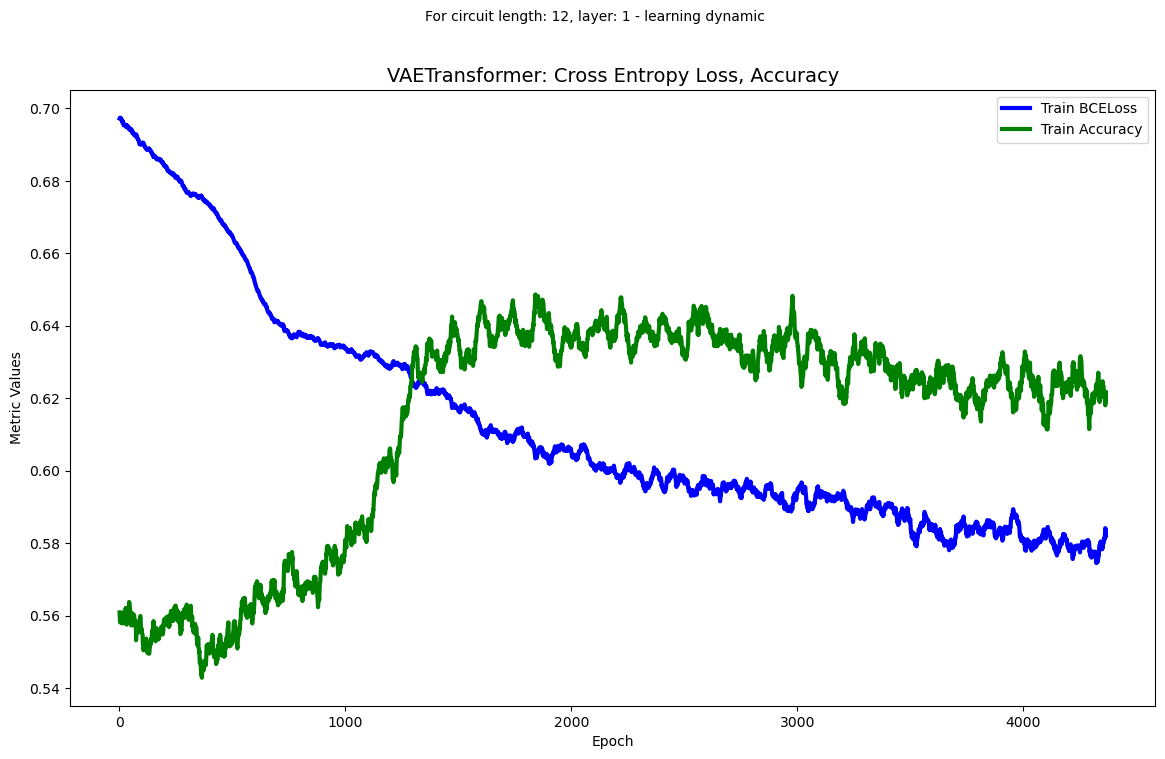

In [98]:
# Plotting Training and Validation
train_Loss_array = np.array(train_Loss_array)
train_BAcc_array = np.array(train_BAcc_array)

window_size = 40
smoothed_train_BCELoss = np.convolve(train_Loss_array, np.ones(window_size)/window_size, mode='valid')
smoothed_train_BAcc = np.convolve(train_BAcc_array, np.ones(window_size)/window_size, mode='valid')

epochs = np.arange(1, len(smoothed_train_BCELoss) + 1)

plt.style.use('default')
plt.figure(figsize=(14, 8))

margin = 0.07  # 5% margin for example
plt.plot(epochs, smoothed_train_BCELoss, color='blue', linestyle='-', linewidth=3, label='Train BCELoss')
upper_bound = smoothed_train_BCELoss * (1 + margin)
lower_bound = smoothed_train_BCELoss * (1 - margin)
#plt.fill_between(epochs, lower_bound, upper_bound, color='blue', alpha=0.6)

plt.plot(epochs, smoothed_train_BAcc, color='green', linestyle='-', linewidth=3, label='Train Accuracy')
upper_bound = smoothed_train_BAcc * (1 + margin)
lower_bound = smoothed_train_BAcc * (1 - margin)
#plt.fill_between(epochs, lower_bound, upper_bound, color='green', alpha=0.6)

#plt.axhline(y=upperBound, color='gray', linestyle=':', linewidth=2)
#plt.text(len(epochs)/2, upperBound + 0.01, f'H(X): ({upperBound:,.5f})', color='black')

plt.title('VAETransformer: Cross Entropy Loss, Accuracy', fontsize=14)
plt.suptitle('For circuit length: 2, layer: 1 - learning dynamic', fontsize=10)
plt.xlabel('Epoch', fontsize=10)
plt.ylabel('Metric Values', fontsize=10)

plt.legend(loc='best', fontsize=10)
plt.show()

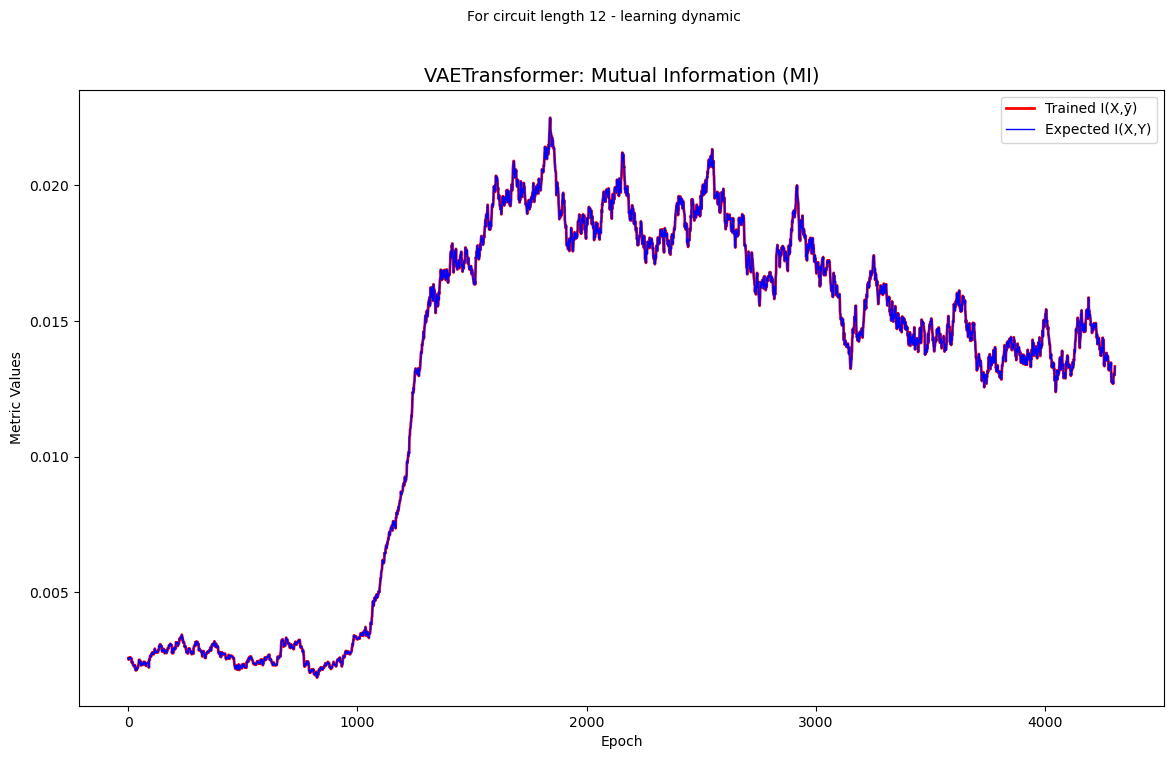

In [97]:
train_MI_array = np.array(train_MI_array)
expected_MI_array = np.array(expected_mutual_info_array)

window_size = 100

smoothed_train_MI = np.convolve(train_MI_array, np.ones(window_size)/window_size, mode='valid')
smoothed_expected_MI = np.convolve(train_MI_array, np.ones(window_size)/(window_size), mode='valid')

MI_difference = expected_MI_array - train_MI_array

epochs = np.arange(1, len(smoothed_train_MI) + 1)

plt.style.use('default')
plt.figure(figsize=(14, 8))

plt.plot(epochs, smoothed_train_MI, color='red', linestyle='-', linewidth=2, label='Trained I(X,ȳ)')
plt.plot(epochs, smoothed_expected_MI, color='blue', linestyle='-', linewidth=1, label='Expected I(X,Y)')

#epochs2 = np.arange(1, len(MI_difference) + 1)
#plt.plot(epochs2, MI_difference, color='gray', linestyle='-', linewidth=2, label='Δ MI')


plt.title('VAETransformer: Mutual Information (MI)', fontsize=14)
plt.suptitle('For circuit length: 2, layer: 1 - learning dynamic', fontsize=10)
plt.xlabel('Epoch', fontsize=10)
plt.ylabel('Metric Values', fontsize=10)

plt.legend(loc='best', fontsize=10)
plt.show()